In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

# 1️⃣ Install compatible versions
# !pip install -q tensorflow==2.15.0 keras==2.15.0 --upgrade --no-cache-dir
# !pip install -q segmentation-models --no-cache-dir


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


In [ ]:
#function for save and load in python/json objects the dictionaries
def save_pickle(dic, path):
    with open(f"{path}", 'wb') as f:
        pickle.dump(dic, f, pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    with open(f"{path}", 'rb',) as f:
        return pickle.load(f)

# create a dataframe with id of the images without extensions (.jpg)
def create_df():
    name = []
    mask = []
    for dirname, _, filenames in os.walk(IMAGE_PATH): # given a directory iterates over the files
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name))).sort_values('id').reset_index(drop=True)

In [ ]:
# Set paths for images and masks
IMAGE_PATH = r"/kaggle/input/semantic-drone-classes/classes_dataset/classes_dataset/original_images"
MASK_PATH  = r"/kaggle/input/semantic-drone-classes/classes_dataset/classes_dataset/label_images_semantic"

X = create_df()['id'].values

In [ ]:
# Train Test Split
X_train, X_val = train_test_split(X, test_size=0.25, random_state=123)
X_test, X_val = train_test_split(X_val, test_size=0.4, random_state=123) # array of indexes

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

In [ ]:
class DroneDatasetTF(Sequence):

    def __init__(self, img_path, mask_path, X, transform=None, batch_size=8):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        masks = []

        for id in batch_ids:
            # Load image and mask as arrays
            image = np.array(Image.open(os.path.join(self.img_path, id + '.png')))
            mask = np.array(Image.open(os.path.join(self.mask_path, id + '.png')))

            # Apply augmentation if available
            if self.transform is not None:
                aug = self.transform(image=image, mask=mask)
                image = aug['image']
                mask = aug['mask']

            # Normalize image and mask using Albumentations Normalize
            norm = A.Normalize()(image=image, mask=np.expand_dims(mask, axis=-1))

            image = norm['image'].astype(np.float32) / 255.0  # Still scale if needed (check if Normalize does this)
            mask = norm['mask'].astype(np.float32)

            images.append(image)
            masks.append(mask)

        # Convert lists to numpy arrays
        images = np.array(images)
        masks = np.array(masks)

        # Ensure masks have shape (batch, height, width, 1)
        if masks.ndim == 3:  # if masks come as (batch, height, width)
            masks = np.expand_dims(masks, axis=-1)
        return images, masks




In [ ]:
import albumentations as A

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.GaussNoise(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.4)
])

valid_transforms = None  # no augmentation on validation/test

batch_size = 3

train_dataset = DroneDatasetTF(IMAGE_PATH, MASK_PATH, X_train, transform=train_transforms, batch_size=batch_size)
valid_dataset = DroneDatasetTF(IMAGE_PATH, MASK_PATH, X_val, transform=valid_transforms, batch_size=batch_size)
test_dataset = DroneDatasetTF(IMAGE_PATH, MASK_PATH, X_test, transform=valid_transforms, batch_size=batch_size)


# Visualize the Dataset

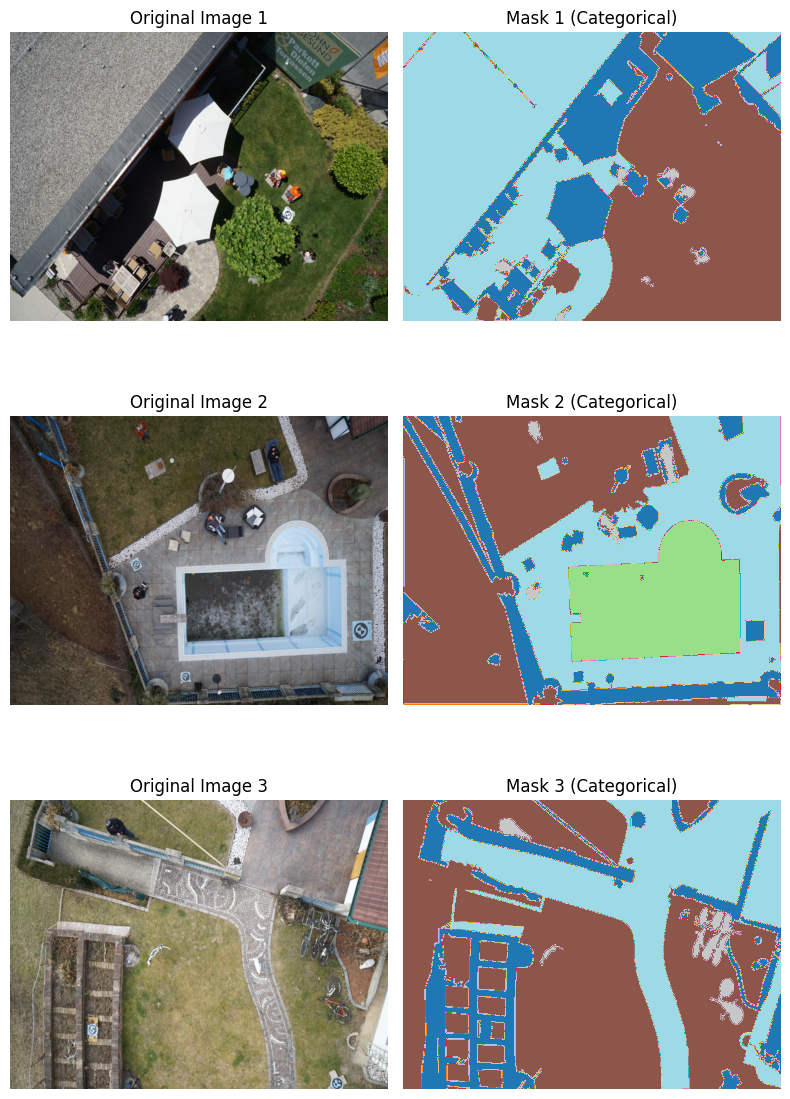

In [28]:
def visualize_samples_colored(dataset, num_samples=3):
    # Just grab raw images without normalization for visualization
    batch_ids = dataset.X[:num_samples]

    plt.figure(figsize=(8, num_samples * 4))
    for i, id in enumerate(batch_ids):
        # Load raw image (without normalization)
        image = np.array(Image.open(os.path.join(dataset.img_path, id + '.png')))

        # Load raw mask (label mask)
        mask = np.array(Image.open(os.path.join(dataset.mask_path, id + '.png')))

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image)
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask, cmap='tab20')  # categorical colormap for multiple classes
        plt.title(f"Mask {i+1} (Categorical)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
visualize_samples_colored(train_dataset, num_samples=3)


In [ ]:
class DroneModelTF(tf.keras.Model):
    def __init__(self, model, criterion, num_classes=5):
        super().__init__()
        self.model      = model
        self.criterion  = criterion
        self.num_classes = num_classes

        # ─── built-in metrics ─────────────────────────────────────
        self.train_iou = tf.keras.metrics.MeanIoU(num_classes=num_classes, name="train_iou")
        self.val_iou   = tf.keras.metrics.MeanIoU(num_classes=num_classes, name="val_iou")
        # ----------------------------------------------------------

        self.train_loss = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss   = tf.keras.metrics.Mean(name="val_loss")
        
    def _logits_to_labels(self, logits):
        # logits: (B,H,W,C)  →  labels: (B,H,W)
        return tf.argmax(logits, axis=-1, output_type=tf.int32)

    def train_step(self, data):
        images, masks = data                     # masks must be int32
        with tf.GradientTape() as tape:
            logits = self(images, training=True)
            loss   = self.criterion(masks, logits)
    
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
    
        preds = self._logits_to_labels(logits)
    
        # ─── update metrics ─────────────────────────────────────────
        self.train_loss.update_state(loss)
        self.train_iou.update_state(masks, preds)
        # ------------------------------------------------------------
        return {"loss": self.train_loss.result(),
                "iou" : self.train_iou.result()}
        
    def test_step(self, data):
        images, masks = data
        logits = self(images, training=False)
        loss   = self.criterion(masks, logits)
    
        preds = self._logits_to_labels(logits)
    
        self.val_loss.update_state(loss)
        self.val_iou.update_state(masks, preds)
    
        return {"loss": self.val_loss.result(),
                "iou" : self.val_iou.result()}
        
    def reset_metrics(self):
        for m in [self.train_loss, self.val_loss,
                  self.train_iou, self.val_iou]:
            m.reset_state()


In [38]:
!pip install segmentation_models

  Using cached segmentation_models-1.0.1-py3-none-any.whl.metadata (938 bytes)
Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)


In [39]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [34]:
import segmentation_models
print(segmentation_models.__version__)


1.0.1


# Building the Model and Training

In [46]:
import tensorflow as tf
import segmentation_models as smp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


CLASSES = 5

# Build model
model = smp.Unet(
    backbone_name='efficientnetb0',
    encoder_weights='imagenet',
    input_shape=(None, None, 3),
    classes=CLASSES,
    activation=None  # logits output
)

# Custom MeanIoU metric for logits
class MeanIoUFromLogits(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='mean_iou_from_logits', **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        return super().update_state(y_true, y_pred_labels, sample_weight)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[MeanIoUFromLogits(num_classes=CLASSES)]
)

# Your train_dataset and valid_dataset must yield (image, mask) pairs, where
# mask is (B,H,W) integer labels, NOT one-hot.


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100


W0000 00:00:1747553494.926102     160 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 1.4221 - mean_iou_from_logits: 0.1584

W0000 00:00:1747553581.689181     158 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1747553587.222710     160 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 1.46314, saving model to best_model.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 629ms/step - loss: 1.4202 - mean_iou_from_logits: 0.1589 - val_loss: 1.4631 - val_mean_iou_from_logits: 0.0715
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.8747 - mean_iou_from_logits: 0.3324
Epoch 2: val_loss improved from 1.46314 to 1.23131, saving model to best_model.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 526ms/step - loss: 0.8743 - mean_iou_from_logits: 0.3325 - val_loss: 1.2313 - val_mean_iou_from_logits: 0.1048
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 0.7049 - mean_iou_from_logits: 0.3467
Epoch 3: val_loss improved from 1.23131 to 1.16224, saving model to best_model.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 541ms/step - loss: 0.7051 - mean_iou_from_logits: 0.3466 - val_loss: 1.1622 - val_mean_iou_from_logits: 0.1860
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - loss: 0.6733 - mean_iou_from_logits: 0.3521
Epoch 4: val_loss imp

In [47]:
model.save('final_model.h5')

# Performance of Model

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_for_display(image):
    """Normalize image to [0,1] for display"""
    image = image - image.min()  # shift to 0
    image = image / (image.max() + 1e-8)  # scale to [0,1]
    return image


def visualize_predictions(model, dataset, class_names=None, num=5):
    count = 0
    for sample in dataset:
        if count >= num:
            break

        if isinstance(sample, dict):
            images, true_masks = sample['image'], sample['mask']
        else:
            images, true_masks = sample

        # Ensure batch dimension
        if images.ndim == 3:
            images = tf.expand_dims(images, 0)
        if true_masks.ndim == 3:
            true_masks = np.expand_dims(true_masks, 0)

        preds = model.predict(images)
        pred_labels = tf.argmax(preds, axis=-1).numpy()

        # Remove this line: true_labels = true_masks.numpy()
        true_labels = true_masks  # already a NumPy array

        for i in range(images.shape[0]):
            image = images[i].numpy() if isinstance(images[i], tf.Tensor) else images[i]
            gt_mask = true_labels[i]
            pred_mask = pred_labels[i]

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            # Make sure it's a float32 image in [0,1] or a uint8 in [0,255]
            image_to_show = normalize_for_display(image)
            plt.imshow(image_to_show)

            plt.title('Input Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='tab20')
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='tab20')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.tight_layout()
            plt.show()



            count += 1
            if count >= num:
                break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


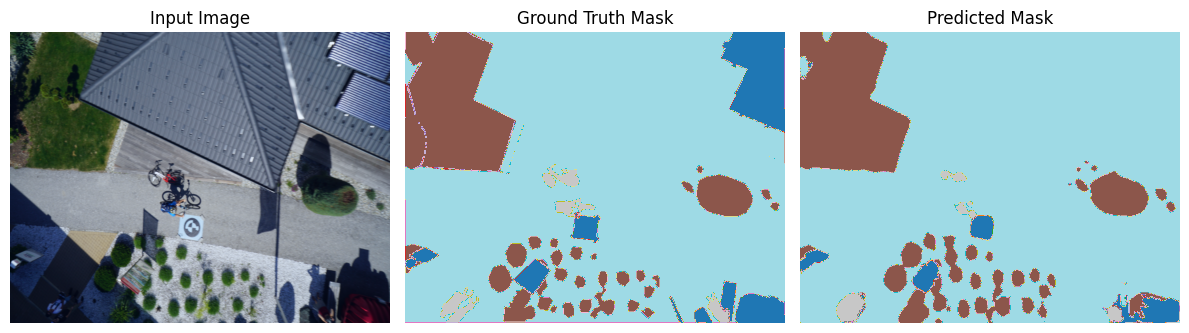

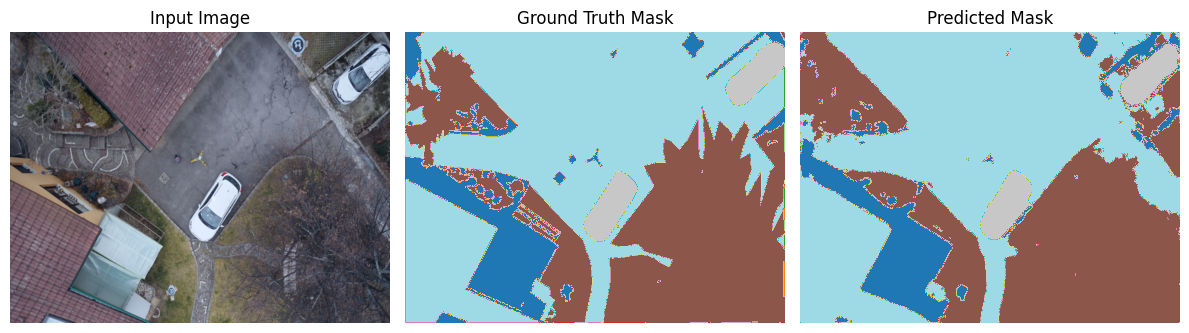

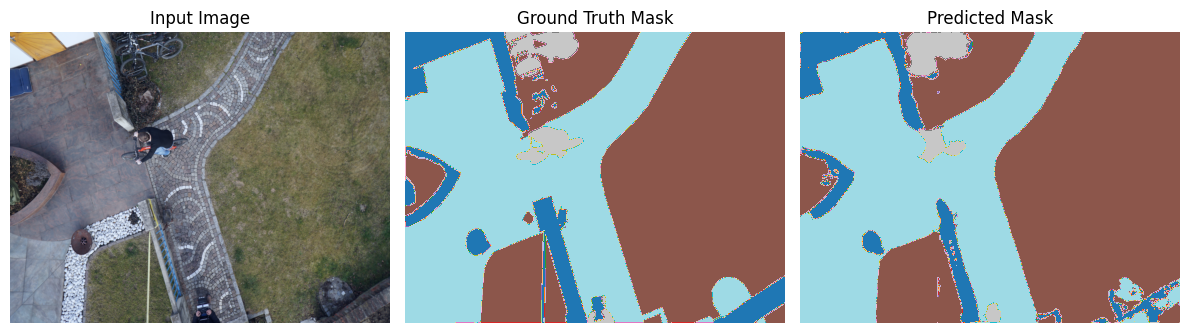

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


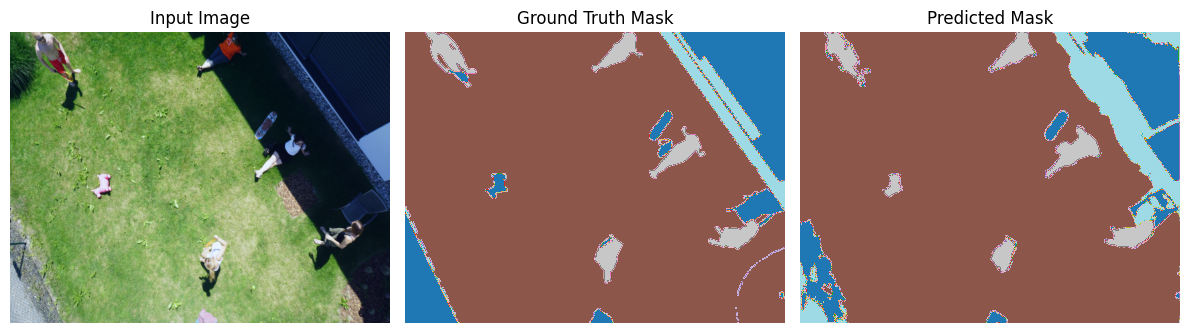

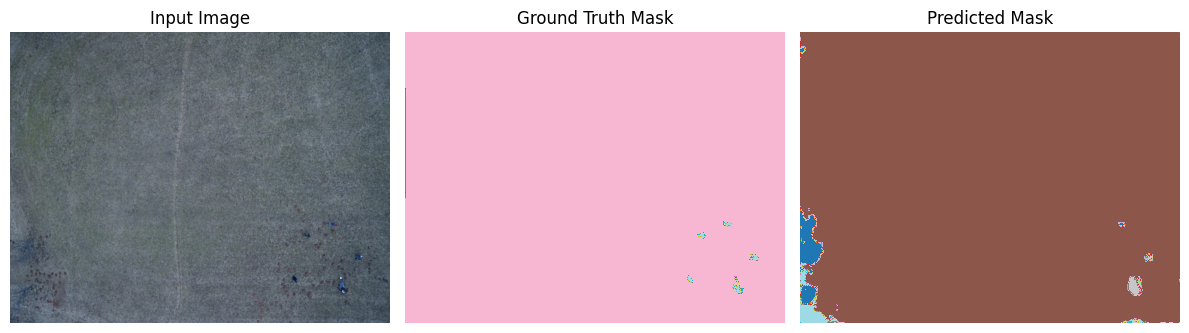

In [70]:
visualize_predictions(model, test_dataset, num=5)


# Training and Validation PLots

Metrics in history: dict_keys(['loss', 'mean_iou_from_logits', 'val_loss', 'val_mean_iou_from_logits'])


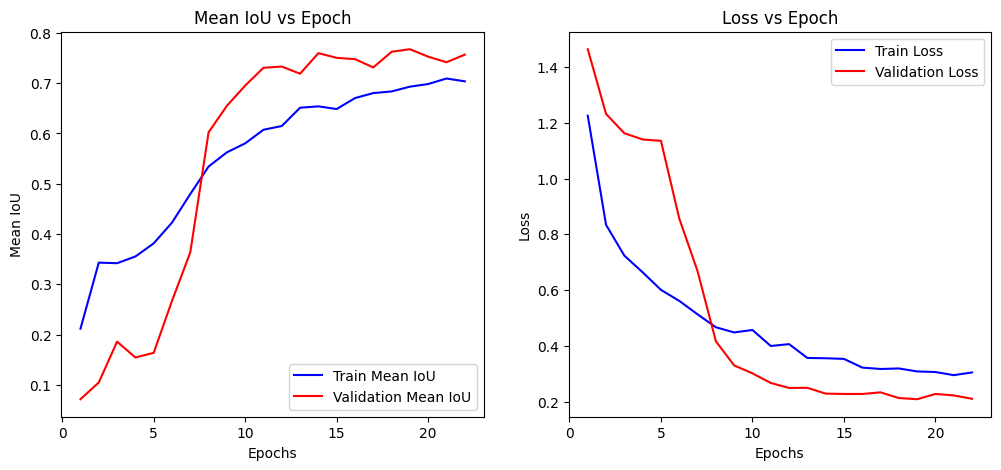

In [71]:
import matplotlib.pyplot as plt

# Plot training & validation Mean IoU and Loss values
def plot_training_history(history):
    # Extract metric names to be sure (MeanIoUFromLogits might be named differently)
    metric_names = history.history.keys()
    print("Metrics in history:", metric_names)  # Optional, helps debug

    # Usually, metric name for MeanIoU will be 'mean_iou_from_logits' or similar
    # Adjust below keys based on what you see printed above

    # For example:
    train_iou_key = 'mean_iou_from_logits'        # Replace with actual metric name if different
    val_iou_key = 'val_mean_iou_from_logits'
    train_loss_key = 'loss'
    val_loss_key = 'val_loss'

    epochs = range(1, len(history.history[train_loss_key]) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Mean IoU
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history[train_iou_key], 'b-', label='Train Mean IoU')
    plt.plot(epochs, history.history[val_iou_key], 'r-', label='Validation Mean IoU')
    plt.title('Mean IoU vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history[train_loss_key], 'b-', label='Train Loss')
    plt.plot(epochs, history.history[val_loss_key], 'r-', label='Validation Loss')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call this after training completes
plot_training_history(history)
